In [3]:
import numpy as np
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST


In [4]:
# 設定參數
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1000  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [5]:

# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [6]:
source_map = np.array(list('1110001110001110011001100')).astype(int)

In [7]:
source_map = source_map.reshape(5, 5)

In [8]:
print('原始資料：')
print(source_map)


原始資料：
[[1 1 1 0 0]
 [0 1 1 1 0]
 [0 0 1 1 1]
 [0 0 1 1 0]
 [0 1 1 0 0]]


In [9]:
filter1 = np.array(list('101010101')).astype(int).reshape(3, 3)

In [10]:
print('\n 濾波器')
print(filter1)


 濾波器
[[1 0 1]
 [0 1 0]
 [1 0 1]]


In [11]:
width = height = source_map.shape[0] - filter1.shape[0] + 1

In [12]:
result = np.zeros((width, height))

In [13]:
for i in range(width):
    for j in range(height):
        value1 =source_map[i:i+filter1.shape[0], j:j+filter1.shape[1]] * filter1
        result[i, j] = np.sum(value1)

In [14]:
print(result)

[[4. 3. 4.]
 [2. 4. 3.]
 [2. 3. 4.]]


In [15]:
import scipy
from scipy.signal import convolve2d

scipy.signal.convolve2d(source_map, filter1, mode = 'valid')

array([[4, 3, 4],
       [2, 4, 3],
       [2, 3, 4]])

In [16]:
from skimage.exposure import rescale_intensity

def convolve(image, kernel):
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    
    pad = int((kW - 1) / 2)
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype = 'float32')
    
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            roi = image[y - pad:y+pad+1, x - pad:x+pad+1]
            k = (roi * kernel).sum()
            output[y-pad,x-pad] = k
    output = rescale_intensity(output, in_range = (0, 255))
    output = (output * 255).astype('uint8')
    return output

In [17]:
import skimage
import cv2
import matplotlib.pyplot as plt
image = skimage.data.chelsea()
cv2.imshow('original', image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow('gray', gray)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
smallBlur = np.ones((7, 7), dtype = 'float') * (1/ (7 * 7))

convoleOutput = convolve(gray, smallBlur)
opencvOutput = cv2.filter2D(gray, -1, smallBlur)
cv2.imshow('little Blur', convoleOutput)

largeBlur = np.ones((21, 21), dtype = 'float') * (1 / (21 * 21))
convoleOutput = cv2.filter2D(gray, -1, largeBlur)
cv2.imshow('large Blur', convoleOutput)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
sharpen = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]], dtype = 'int')
convoleOutput = convolve(gray, sharpen)
opencvOutput = cv2.filter2D(gray, -1, sharpen)
cv2.imshow('sharpen', convoleOutput)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
laplacian = np.array(([0, 1, 0],
                     [1, -4, 1],
                     [0, 1, 0]), dtype = 'int')

convoleOutput = convolve(gray, laplacian)
opencvOutput = cv2.filter2D(gray, -1, laplacian)
cv2.imshow('laplacian edge detection', opencvOutput)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
import torch.nn as nn
class ConvNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size = 5, stride = 1, padding = 2),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim = 1)
        return out

In [22]:
model = ConvNet().to('cuda')

In [23]:
import math 

In [24]:
def Conv_Width(W, F, P, S):
    return math.floor((W - F + 2 * P) / S + 1 )
def Conv_Output_Volume(W, F, P, S, out):
    return  Conv_Width(W, F, P, S) ** 2 * out

In [25]:
def Conv_Parameter_Count(F, C, out):
    return F ** 2 * out
def Pool_Width(W, F, P, S):
    return Conv_Width(W, F, P, S)
def Pool_Output_Volume(W, F, P, S, filter_count):
    return Conv_Output_Volume(W, F, P, S, filter_count)
def Pool_Parameter_Count(W, F, S):
    return 0

In [26]:
c1_Width = Conv_Width(28, 5, 2, 1)
p1_Width = Pool_Width(c1_Width, 2, 0, 2)
c2_Width = Conv_Width(p1_Width, 5, 2, 1)
p2_out = Pool_Output_Volume(c2_Width, 2, 0, 2, 32)
p2_out, 7 * 7 * 32

(1568, 1568)

In [27]:
for name, module in model.named_children():
    print(f'{name}: {module}')

layer1: Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
layer2: Sequential(
  (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
fc: Linear(in_features=1568, out_features=10, bias=True)


In [28]:
epochs = 10
lr = 0.1

train_loader = DataLoader(train_ds, shuffle = True, batch_size = BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model.train()
loss_list = []
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [10000 / 60000] (17 %)  Loss: 4.145321
Epoch 1: [20000 / 60000] (33 %)  Loss: 2.320362
Epoch 1: [30000 / 60000] (50 %)  Loss: 2.382642
Epoch 1: [40000 / 60000] (67 %)  Loss: 2.302213
Epoch 1: [50000 / 60000] (83 %)  Loss: 2.297704
Epoch 1: [60000 / 60000] (100 %)  Loss: 2.290435
Epoch 2: [10000 / 60000] (17 %)  Loss: 2.265286
Epoch 2: [20000 / 60000] (33 %)  Loss: 2.136955
Epoch 2: [30000 / 60000] (50 %)  Loss: 1.692392
Epoch 2: [40000 / 60000] (67 %)  Loss: 0.841247
Epoch 2: [50000 / 60000] (83 %)  Loss: 0.515344
Epoch 2: [60000 / 60000] (100 %)  Loss: 0.372375
Epoch 3: [10000 / 60000] (17 %)  Loss: 0.280030
Epoch 3: [20000 / 60000] (33 %)  Loss: 0.255955
Epoch 3: [30000 / 60000] (50 %)  Loss: 0.182636
Epoch 3: [40000 / 60000] (67 %)  Loss: 0.220969
Epoch 3: [50000 / 60000] (83 %)  Loss: 0.157147
Epoch 3: [60000 / 60000] (100 %)  Loss: 0.174591
Epoch 4: [10000 / 60000] (17 %)  Loss: 0.182194
Epoch 4: [20000 / 60000] (33 %)  Loss: 0.163435
Epoch 4: [30000 / 60000] (50 %)  Loss

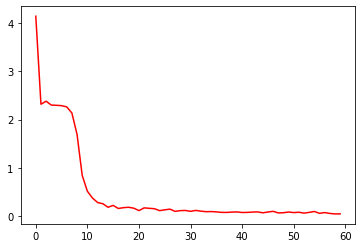

In [29]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

In [30]:
test_loader = DataLoader(test_ds, shuffle = False, batch_size = BATCH_SIZE)
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        test_loss += F.nll_loss(output, target).item()
        
        output = model(data)
        
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
test_loss /= len(test_loader.dataset)

batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失:{test_loss:.4f}, 準確率: {correct} / {data_count}'+
      f'({percentage:2f}%)\n')

平均損失:0.0001, 準確率: 9794 / 10000(97.940000%)



In [31]:
prediction = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis = -1)
        prediction.append(str(output.item()))
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(prediction[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


In [32]:
import numpy as np

i=18
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

torch.Size([1, 1, 28, 28])
0~9預測機率: [[0.   0.   0.   0.99 0.   0.01 0.   0.   0.   0.  ]]
0~9預測機率: [3]


In [33]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

In [34]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.1307), std = (0.3108))])
train_ds = MNIST(PATH_DATASETS, train = True, download = True, transform = transform)
test_ds = MNIST(PATH_DATASETS, train = False, download = True, transform = transform)
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [36]:
import math

# W, F, P, S：image Width, Filter width, Padding, Stride 
# def Conv_Width(W, F, P, S):
#     return math.floor(((W - F) + 2 * P) / S) + 1

# # def Pool_Width(W, F, S):
#     return math.floor((W - F) / S) + 1

def Conv_Width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def Conv_Output_Volume(W, F, P, S, out):
    return Conv_Width(W, F, P, S) ** 2 * out

# C: no of channels
def Conv_Parameter_Count(F, C, out):
    return F ** 2 * C * out

def Pool_Width(W, F, P, S):
    return Conv_Width(W, F, P, S)

# filter_count: no of filter in last conv 
# stride count default value = Filter width
def Pool_Output_Volume(W, F, P, S, filter_count):
    return Conv_Output_Volume(W, F, P, S, filter_count)

def Pool_Parameter_Count(W, F, S):
    return 0

def Conv_Pool_Width(W, F, P, S, F2, P2, S2, n):
    for i in range(n):
        W = Pool_Width(Conv_Width(W, F, P, S), F2, P2, S2)
    return W

In [37]:
# ConvNet2
l2_Width = Conv_Width(Conv_Width(28, 3, 0, 1), 3, 0, 1)
p1_out = Pool_Output_Volume(l2_Width, 2, 0, 2, 64)
l2_Width, p1_out

(24, 9216)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])
batch_size = 8


train_ds = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 16)

Files already downloaded and verified


In [3]:
test_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=16)


Files already downloaded and verified


In [4]:
print(train_ds.data.shape, test_ds.data.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    


In [ ]:
dataiter = iter(train_loader)


In [ ]:
images, labels = dataiter.next()
print(images.shape)
plt.figure(figsize = (10, 6))
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_tmp)))

In [ ]:
import PIL.Image as Image

data_shape = data.shape
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = Image.open(uploaded_file)

In [4]:

import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np

In [5]:
# 設定參數
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1000  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [6]:
image_width = 28
train_transforms = transforms.Compose([
    #transforms.ColorJitter(), # 亮度、飽和度、對比資料增補
    # 裁切部分圖像，再調整圖像尺寸
    transforms.RandomResizedCrop(image_width, scale=(0.8, 1.0)), 
    transforms.RandomRotation(degrees=(-10, 10)), # 旋轉 10 度
    #transforms.RandomHorizontalFlip(), # 水平翻轉
    #transforms.RandomAffine(10), # 仿射
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

test_transforms = transforms.Compose([
    transforms.Resize((image_width, image_width)), # 調整圖像尺寸
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

In [7]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True,  
                 transform=test_transforms)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [9]:
# Conv2d 參數： in-channel, out-channel, kernel size, Stride, Padding
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [10]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss_list = []    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    return loss_list

In [21]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # print(data.shape)
            # print(target)
            if type(data) == tuple:
                data = torch.FloatTensor(data)
            if type(target) == tuple:
                target = torch.Tensor(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            correct += (predicted == target).sum().item()
    # 平均損失
    test_loss /= len(test_loader.dataset) 
    # 顯示測試結果
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'準確率: {correct}/{data_count} ({percentage:.2f}%)')


In [12]:
epochs = 5
lr=1

# 建立模型
model = Net().to(device)

# 損失
criterion = F.nll_loss # nn.CrossEntropyLoss()

# 設定優化器(optimizer)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, criterion, optimizer, epoch)
    #test(model, device, test_loader)
    optimizer.step()


Epoch 1: [10000 / 60000] (17 %)  Loss: 1.674732
Epoch 1: [20000 / 60000] (33 %)  Loss: 0.772319
Epoch 1: [30000 / 60000] (50 %)  Loss: 0.869491
Epoch 1: [40000 / 60000] (67 %)  Loss: 0.442964
Epoch 1: [50000 / 60000] (83 %)  Loss: 0.425390
Epoch 1: [60000 / 60000] (100 %)  Loss: 0.345404
Epoch 2: [10000 / 60000] (17 %)  Loss: 0.261057
Epoch 2: [20000 / 60000] (33 %)  Loss: 0.371214
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.315251
Epoch 2: [40000 / 60000] (67 %)  Loss: 0.238413
Epoch 2: [50000 / 60000] (83 %)  Loss: 0.214542
Epoch 2: [60000 / 60000] (100 %)  Loss: 0.262070
Epoch 3: [10000 / 60000] (17 %)  Loss: 0.175198
Epoch 3: [20000 / 60000] (33 %)  Loss: 0.183462
Epoch 3: [30000 / 60000] (50 %)  Loss: 0.190803
Epoch 3: [40000 / 60000] (67 %)  Loss: 0.213597
Epoch 3: [50000 / 60000] (83 %)  Loss: 0.142181
Epoch 3: [60000 / 60000] (100 %)  Loss: 0.167363
Epoch 4: [10000 / 60000] (17 %)  Loss: 0.157973
Epoch 4: [20000 / 60000] (33 %)  Loss: 0.181480
Epoch 4: [30000 / 60000] (50 %)  Loss

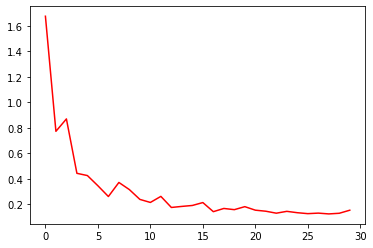

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

In [20]:
test(model, device, test_loader)


tensor([-4.1603e-05, -2.5868e-05, -4.8792e-04, -2.1413e-03, -9.1787e-05,
        -3.6257e-04, -2.0262e-03, -1.6740e-02, -1.0304e-02, -4.5337e-04,
        -4.9947e-05, -5.0782e-05, -1.0967e-05, -3.4571e-06, -1.4173e-04,
        -1.3850e-02, -5.2570e-05, -2.3126e-05, -7.3691e-01, -1.6570e-05,
        -5.5631e-04, -1.9612e-03, -7.6860e-04, -6.2702e-05, -4.1607e-04,
        -1.2700e-03, -1.4432e-03, -3.5763e-07, -7.1476e-04, -2.1543e-03,
        -1.9073e-06, -3.8279e-03, -1.1921e-07, -1.2398e-05, -4.7756e-04,
        -9.4175e-06, -8.3553e-03, -5.4738e-04, -4.8101e-04, -1.1876e-03,
        -3.4982e-04, -1.9458e-02, -7.6634e-04, -5.6746e-03, -6.1629e-05,
        -1.4070e-03, -2.4349e-02, -8.9407e-06, -3.1609e-04, -7.6053e-05,
        -5.8768e-05, -6.6159e-05, -1.0275e-04, -4.4631e-03, -1.5616e-05,
        -7.1525e-06, -5.9605e-07, -4.8363e-04, -4.3510e-05, -1.2661e-02,
        -2.8491e-05, -4.3347e-04, -1.9090e-01, -5.7151e-03, -5.7752e-04,
        -6.5243e-03, -4.8042e-04, -2.2683e-04, -1.3

tensor([-5.8944e-04, -6.6540e-03, -1.6640e-04, -4.2795e-05, -1.6430e-02,
        -1.3875e-04, -6.5914e-03, -2.9802e-06, -2.9802e-06, -7.0994e-03,
        -2.7119e-03, -6.3181e-06, -8.3446e-07, -1.9615e-03, -1.3076e-04,
        -1.1210e-03, -5.7246e-01, -9.9502e-04, -1.3294e+00, -9.1787e-05,
        -3.0994e-06, -2.5794e-04, -2.7545e-04, -1.8842e-03, -2.0927e-01,
        -3.9317e-03, -1.0729e-05, -1.0220e-02, -2.3318e-01, -9.5405e-04,
        -3.3974e-05, -2.3842e-07,  0.0000e+00, -8.0701e-05, -2.3017e-04,
        -5.8751e-02, -5.2096e-03, -1.6604e-03, -8.6661e-05, -5.0115e-04,
        -5.4071e-01, -2.5317e-04, -1.2755e-05, -4.1436e-02, -1.3883e-03,
        -4.7684e-07, -4.1007e-05, -4.7022e-03, -1.4403e-01, -3.8306e-02,
        -4.4896e-04, -3.0987e-03, -9.6787e-03, -4.7237e-01, -1.0447e-03,
        -9.9097e-04, -2.7895e-05, -1.4143e-03, -1.8316e-03, -1.8996e-03,
        -4.0151e-03, -1.0448e-03, -7.3909e-06, -2.5531e-01, -3.7377e-04,
        -9.1668e-05, -6.2125e-04, -2.8558e-04, -3.7

tensor([-1.0606e-03, -3.2085e-03, -4.6511e-03, -4.1543e-03, -9.5367e-07,
        -6.8284e-04, -2.3842e-07, -3.6001e-05, -2.9563e-05, -5.6028e-06,
        -5.3644e-06, -3.5763e-07, -1.5259e-05, -2.3603e-05, -3.5101e-04,
        -1.5949e-04, -4.0530e-05, -9.4886e-05, -2.8407e-03, -3.0453e-04,
        -1.4665e-03, -4.4490e-02, -5.6980e-05, -2.2004e-04, -1.3113e-06,
        -2.6345e-05, -1.3113e-06, -4.7684e-07, -6.2792e-04, -2.6008e-04,
        -4.3068e-02, -1.2404e-02, -2.3545e-03, -1.8082e-04, -2.3842e-07,
        -3.1289e-03, -5.9605e-07, -3.3957e-04, -2.1458e-06, -2.9087e-05,
        -1.1563e-05, -1.0953e-03, -9.1791e-06, -4.8030e-04, -3.4791e-04,
        -9.6559e-06, -8.2254e-06, -6.8424e-05, -9.5298e-04, -2.5244e-02,
        -1.2948e-03, -9.6561e-04, -3.4928e-05, -7.9481e-04, -3.4518e-02,
        -1.1921e-07, -9.5367e-07, -1.0252e-05, -1.4972e-04, -9.3333e-04,
        -1.2994e-05, -1.0246e-03, -6.3656e-05, -1.9560e-04, -6.7176e-03,
        -3.5763e-07, -1.1921e-07, -8.9407e-06, -2.1

準確率: 9861/10000 (98.61%)


In [22]:
import matplotlib.pyplot as plt

def imshow(X):
    # 繪製點陣圖，cmap='gray':灰階
    plt.imshow(X.reshape(28,28), cmap='gray')

    # 隱藏刻度
    plt.axis('off') 

    # 顯示圖形
    plt.show() 

In [26]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4


In [30]:
import PIL.Image as Image

data_shape = data.shape

for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = Image.open(uploaded_file).convert('L')

    # 縮為 (28, 28) 大小的影像
    image_resized = image1.resize(tuple(data_shape)[2:])
    X1 = np.array(image_resized).reshape([1]+list(data_shape)[1:])
    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-(X1/255)

    # 圖像轉換
    X1 = (X1 - 0.1307) / 0.3081  
    
    # 顯示轉換後的圖像
    # imshow(X1)
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    output = model(X1)
    # print(output, '\n')
    _, predicted = torch.max(output.data, 1)
    print(f'actual/prediction: {i} {predicted.item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 9


In [31]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None
                 , to_gray=False, size=28):
        self.img_labels = [file_name for file_name in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.to_gray = to_gray
        self.size = size

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 組合檔案完整路徑
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        # 讀取圖檔
        mode = 'L' if self.to_gray else 'RGB'
        image = Image.open(img_path, mode='r').convert(mode)
        image = Image.fromarray(1.0-(np.array(image)/255))

        # print(image.shape)
        # 去除副檔名
        label = int(self.img_labels[idx].split('.')[0])
        
        # 轉換
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [32]:
ds = CustomImageDataset('./myDigits', to_gray=True, transform=test_transforms)
data_loader = torch.utils.data.DataLoader(ds, batch_size=10,shuffle=False)

test(model, device, data_loader)

準確率: 9/10 (90.00%)


In [33]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in data_loader:
        print(target)
        data, target = data.to(device), target.to(device)
        
        # 預測
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        print(predicted)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 3, 8, 9], device='cuda:0')


In [34]:
torch.save(model, 'cnn_augmentation_model.pt')

In [1]:
from tkinter import *
from PIL import ImageDraw, Image, ImageGrab
import numpy as np
from skimage import color
from skimage import io
import os
import io 
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
class Paint():
    def __init__(self):
        self.root = Tk()
        self.root.title('手寫阿拉伯數字辨識系統')
        self.c = Canvas(self.root, bg = 'white', width = 280, height = 280)
        self.image1 = Image.new('RGB', (280, 280), color = 'white')
        self.draw = ImageDraw.Draw(self.image1)
        self.c.grid(row = 1, columnspan = 6)
        self.classify_button = Button(self.root, text = '辨識', command = lambda: self.classify(self.c))
        self.classify_button.grid(row=0, column=0, columnspan=2, sticky='EWNS')
        self.clear = Button(self.root, text='清畫面', command=self.clear)
        self.clear.grid(row=0, column=2, columnspan=2, sticky='EWNS')
        self.savefile = Button(self.root, text='存檔', command=self.savefile)
        self.savefile.grid(row=0, column=4, columnspan=2, sticky='EWNS')
        self.prediction_text = Text(self.root, height=2, width=10)
        self.prediction_text.grid(row=2, column=4, columnspan=2)
        self.setup()
        self.root.mainloop()
        def setup(self):
            self.old_x = None
            self.old_y = None
            self.line_width = 15
            self.color = 'black'

            # 定義滑鼠事件處理函數，包括移動滑鼠及鬆開滑鼠按鈕
            self.c.bind('<B1-Motion>', self.paint)
            self.c.bind('<ButtonRelease-1>', self.reset)
        def loadModel():
        model = torch.load('cnn_augmentation_model.pt').to(device)
        return model

In [3]:
!pip install torchsummary

In [4]:
import torch
from torchvision import models
from torch import nn
import numpy as np
from torchsummary import summary

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [6]:
rn18 = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ian/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
children_counter = 0
for n, c in rn18.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [8]:
rn18._modules

OrderedDict([('conv1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('bn1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('relu', ReLU(inplace=True)),
             ('maxpool',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('layer1',
              Sequential(
                (0): BasicBlock(
                  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (1): BasicBlock(
         

In [9]:
from torchsummary import summary

In [14]:
summary(rn18.to(device), input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [25]:
class new_model(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = models.resnet18(pretrained=True)
        self.children_list = []
        # 依序取得每一層
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            # 找到特定層即終止
            if n == self.output_layer:
                print('found !!')
                break

        # 建構新模型
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x
    
model = new_model(output_layer = 'layer1')
model = model.to(device)    

found !!


In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 

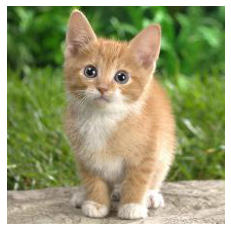

torch.Size([1, 64, 56, 56])

In [26]:
img = Image.open('./images_test/cat.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

resize = transforms.Resize([224, 224])
img = resize(img)
to_tensor = transforms.ToTensor()
img = to_tensor(img).to(device)
img = img.reshape(1, *img.shape)
out = model(img)
out.shape

In [28]:
img.size()

torch.Size([1, 3, 224, 224])

In [40]:
for fmap in out.cpu().detach().numpy():
    print(fmap)

[[[0.33322445 0.37721127 0.16389814 ... 0.5233886  0.36007366 0.13482127]
  [0.52929914 0.6820045  0.30843475 ... 0.9833116  0.5737692  0.32656103]
  [0.50821334 0.685259   0.32223198 ... 1.1010102  0.72878504 0.317515  ]
  ...
  [0.33017728 0.3825683  0.7451759  ... 1.0137472  1.4764199  0.99902993]
  [0.37085226 0.5006115  0.5208976  ... 1.0305015  1.4467831  1.1119244 ]
  [0.25445497 0.37486854 0.3783216  ... 0.49791598 0.319816   0.45630968]]

 [[0.7406203  0.5840038  0.7380225  ... 0.2816836  1.2479638  0.9628156 ]
  [0.505671   0.4115139  0.7122197  ... 0.39449787 1.266495   0.7458575 ]
  [0.08752131 0.         0.         ... 0.78220004 1.2672894  0.6011936 ]
  ...
  [1.3891416  0.7295197  0.59379494 ... 0.5478587  0.8239895  0.19786033]
  [1.3916128  1.019933   0.8961951  ... 1.3253412  1.4838003  0.51591396]
  [1.0701072  0.7958455  0.75491154 ... 0.3997166  0.6779934  0.36182046]]

 [[0.40115535 0.7032509  0.7551468  ... 0.56481963 0.45162943 0.26581752]
  [0.3970874  0.427885

In [41]:
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


In [42]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [45]:
from torchvision.datasets import MNIST

batch_size = 128
num_epochs = 2

# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST('.', train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST('.', train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

model = Net().to(device)    

In [66]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [67]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.327538
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.198411
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.194914
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.184808
tensor([8, 5, 3, 9, 0, 5, 2, 9, 9, 8, 0, 2, 6, 7, 2, 9], device='cuda:0')

Test set: Average loss: 0.0008, Accuracy: 9743/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.175514
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.220527
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.217630
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.244319
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.208716
tensor([3, 4, 1, 9, 4, 4, 3, 9, 1, 7, 8, 5, 4, 4, 3, 8], device='cuda:0')

Test set: Average loss: 0.0007, Accuracy: 9758/10000 (98%)



In [58]:
a, b = train_ds[1]

In [68]:
# 以前面 100 筆為背景值， 計算 Shapley Value
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)

background = images[:100]
test_images = images[100:105]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)   

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [80]:
np.shape(shap_values)

(10, 5, 1, 28, 28)